In [297]:
import requests                  
import pandas as pd              
import numpy as np               
import matplotlib.pyplot as plt  
import time            
        
from tqdm import tqdm_notebook   
import vk
import pickle
import itertools

import plotly as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

import pymorphy2
from multiprocessing import Pool
import re
from nltk.corpus import stopwords
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from collections import Counter
from wordcloud import WordCloud

In [339]:
my_id = '567890010'

# session = vk.Session(access_token=access_token_d_3)
# my_api = vk.API(session, v='5.21')

In [333]:
token_array = []
    

session_array = [vk.Session(access_token=token) for token in token_array]
api_array = [vk.API(session, v='5.21') for session in session_array]

In [334]:
session_array = [vk.Session(access_token=token) for token in token_array]

In [335]:
api_array = [vk.API(session, v='5.21') for session in session_array]

In [327]:
user_info = my_api.users.get(user_ids=1)
print(user_info)
start_id = user_info[0]['id']

[{'id': 1, 'first_name': 'Павел', 'last_name': 'Дуров'}]


In [328]:
my_api.wall.get(owner_id = my_id)['items']

[{'id': 3266,
  'from_id': 567890010,
  'owner_id': 567890010,
  'date': 1583390745,
  'post_type': 'post',
  'text': 'Я принял участие в голосовании «Благоустройство парка Северного речного вокзала      » в проекте «Активный гражданин» и получил 20 баллов',
  'can_delete': 1,
  'can_pin': 1,
  'can_archive': True,
  'is_archived': False,
  'attachments': [{'type': 'link',
    'link': {'url': 'https://ag.mos.ru/poll/7201?ref=-Y_d5iO5ch',
     'title': 'Активный Гражданин - проект для тех, кому важно, что происходит в Москве',
     'description': 'Ты решаешь! Электронные голосования правительства Москвы.',
     'target': 'internal',
     'image_src': 'https://sun9-5.userapi.com/c855124/v855124509/203a7c/sAWFQg9-N9E.jpg'}}],
  'post_source': {'type': 'api'},
  'comments': {'count': 0, 'can_post': 1, 'groups_can_post': True},
  'likes': {'count': 1, 'user_likes': 0, 'can_like': 1, 'can_publish': 1},
  'reposts': {'count': 1,
   'wall_count': 0,
   'mail_count': 0,
   'user_reposted': 0}},

In [8]:
[item['likes']['count'] for item in my_api.wall.get(owner_id = my_id)['items']]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

Ура, оно работает, попытаемся сделать что-то полезное

Примерный план полезного у нас такой:

Давай начнём с какого нибудь вк. Действовать будем таким путём - обозначим какую нибудь тему за которой мы хотим мониторить - нууу например обучение (можно что угодно ещё)

Возьмём за основу какие нибудь группы популярные где такое есть - ну гик брейнс, можно шад, что нибудь такое. Будем парсить их посты через апишку и подписчиков. У подписьючиков будем искать ещё группы и смотреть потенциальные места и рассчирять список групп, у постов будем смотреть охватность и искать какие нибудь маркерные слова что это рекламный пост (ну или явную запись что пост рекламный), сверять охватности

Вот собственно план на начало)

Потом между постами будем искать модельки близости


https://vk.com/geekbrainsru - первая цель. Украдём посты и подписичников

In [329]:
id_geek = '15365973'
id_volley = '65570928'

In [22]:
my_api.wall.get(owner_id=id_geek, count = 5)['items']

[{'id': 1296470,
  'from_id': -15365973,
  'owner_id': -15365973,
  'date': 1599493080,
  'marked_as_ads': 0,
  'post_type': 'post',
  'text': 'Вместо мишени — данные. Вместо винтовки — командная строка. Вместо шума болельщиков — тихий, размеренный гул процессорного вентилятора. Вместо проторенной лыжни разум мчится к цели новыми, неизведанными тропами, сквозь файрволы, аутентификации и все возможные скрипты. Да, это не хуже какого-нибудь биатлона — соревнования Capture the Flag для знатоков инфобезопасности.\n\nВ третьем выпуске подкаста мы поговорим о таких вот играх разума с тем, кто организует их в GeekBrains — Виктором Чаплыгиным, администратором CTF-стенда для студентов-кибербезопасников в GeekUniversity и GeekSchool. Да, и GeekSchool в том числе — это именно тот случай, когда школьные олимпиады могут выйти из класса 😉',
  'attachments': [{'type': 'podcast',
    'podcast': {'artist': 'GeekBrains',
     'id': 456239069,
     'owner_id': -15365973,
     'title': 'Эпизод 3. CTF (Cap

In [23]:
#крадем лайки с первых 5 постов, чтобы убедиться, что всё работает

[item['likes']['count'] for item in my_api.wall.get(owner_id=id_geek, count = 5)['items']]

[39, 40, 12, 17, 67]

In [76]:
my_api.wall.get(owner_id = '-'+id_geek)['count']

5436

In [330]:
def pars_group(group_id, api_array): 
    # В этот словарик будем собирать информацию о текстах, можно напихать что-нибудь еще
    wall_inf = {'text' : [ ],
               'id' : [ ]}
    
    # Это не многопоточность, но мне показалось, что нам надо вызывать не саму функцию несколько раз с разными
    # токенами в разных потоках, а внутри функции менять значения токенов. Отсюда родилась такая идея.
    # Делаем итератор из нашего массива, бесконечно гоняем его по кругу, уменьшаем время между запросами
    
    iter_api = itertools.cycle(api_array)
    len_api = len(api_array)
    my_api = next(iter_api)
    

    # Выясним сколько всего в группе постов 
    n = my_api.wall.get(owner_id = '-' + group_id)['count']
    print('В группе ', n, 'постов')

    for i in tqdm_notebook(range(0, n + 100, 100)): 
        # После каждого запроса будем ждать 0.4 секунды, иначе вк не отдаст данные. 
        # Меняем время ожидания из идеи, что ВК отдает нам 3 запроса в секунду на токен
#         time.sleep(1/(3 * len_api))
        my_api = next(iter_api)
        wall = my_api.wall.get(owner_id = '-' + group_id, count = 100, offset = str(i))['items']
        # Вытащили тексты постов и id
        new_text = [item['text'] for item in wall]
        post_ids = [item['id'] for item in wall]
        # Закинули всё это добро в словарик с данными 
        wall_inf['text'].extend(new_text)
        wall_inf['id'].extend(post_ids)
    return wall_inf


In [331]:
def pars_group_old(group_id): 
    # В этот словарик будем собирать информацию о текстах, можно напихать что-нибудь еще
    wall_inf = {'text' : [ ],
               'id' : [ ]}
    

    # Выясним сколько всего в группе постов 
    n = my_api.wall.get(owner_id = '-' + group_id)['count']
    print('В группе ', n, 'постов')

    for i in tqdm_notebook(range(0, n + 100, 100)): 
        # После каждого запроса будем ждать 0.4 секунды, иначе вк не отдаст данные. 
        # Меняем время ожидания из идеи, что ВК отдает нам 3 запроса в секунду на токен
#         time.sleep(0.4)
        wall = my_api.wall.get(owner_id = '-' + group_id, count = 100, offset = str(i))['items']
        # Вытащили тексты постов и id
        new_text = [item['text'] for item in wall]
        post_ids = [item['id'] for item in wall]
        # Закинули всё это добро в словарик с данными 
        wall_inf['text'].extend(new_text)
        wall_inf['id'].extend(post_ids)
    return wall_inf


Интересно, с одним токеном стена парсится 5 +/- секунд, с 4 токенами 2.5 +/- секунд. В 4 раза больше токенов, но прирост по скорости только в 2 раза... Кажется время в слипе можно еще порезать...  

ПОСЛЕ КАКОГО-ТО КОЛИЧЕСТВА времени и проведенных експериментов оказалось, что у меня настолько жопорукий код, что строку с time.sleep() вообще можно закомментить... и стена прекрасно парсится 😅😅😅 иии не надо никакой сотни токенов

Посмотрим, будет ли от этого толк в других функциях

In [336]:
%%time
pars_wall = pars_group(id_volley, api_array=api_array)

В группе  532 постов



CPU times: user 255 ms, sys: 7.41 ms, total: 263 ms
Wall time: 3.47 s


In [123]:
%%time
pars_wall = pars_group_old(id_volley)

В группе  532 постов



CPU times: user 193 ms, sys: 21.4 ms, total: 214 ms
Wall time: 2.31 s


In [125]:
%%time
pars_wall_football = pars_group(group_id='26028117', api_array=api_array)

В группе  57149 постов



CPU times: user 14.9 s, sys: 847 ms, total: 15.7 s
Wall time: 5min 32s


In [337]:
%%time
pars_wall_football = pars_group_old(group_id='26028117')

In [177]:
df_post = pd.DataFrame(pars_wall)
df_post.head()

,text,id
0,"Всем привет! Подскажите пожалуйста, где проход...",2913
1,Всем привет!\nТолько переехал в Мытищи. Подска...,2910
2,Здравствуйте. А в 27 школееще игры собираются?...,2905
3,Приглашаем любителей спорта на игры:\n- ВОЛЕЙБ...,2904
4,Прекрасные летние игры! 😍😍😍\n#волейбол #мытищи...,2900


Отлично, мы умеем получать текст и id постов из рандомных групп. Теперь поучимся считать охват.

In [110]:
def pars_comment(pars_wall, api_array, group_id):    
    comments_id = []
    commentator_id = {}
    
    iter_api = itertools.cycle(api_array)
    len_api = len(api_array)
    my_api = next(iter_api)

    for post_id in tqdm_notebook(pars_wall['id']):
        my_api = next(iter_api)
        info = my_api.wall.getComments(owner_id= '-' + group_id, post_id=post_id)['items']
        topic = [
            {            
                'comment_id': item['id'],
                'post_id' : post_id
            } for item in info
        ]
        comments_id.extend(topic)

        time.sleep(1/(3 * len_api))
        
        dict_id_commenst = [
            {
                'user_id': item['from_id']
            } for item in info
        ]

        commentator_id[post_id] = dict_id_commenst
        
        
        
    print('В группе ', len(comments_id), 'комментариев')
    
    df_post_user = pd.DataFrame([(comment) for comment in commentator_id.items()], 
                                columns=['id', 'user_id_comment'])
    df_post_user['user_id_comment'] = df_post_user['user_id_comment'].apply(lambda x: [id['user_id'] for id in x])
    df_post_user.set_index('id', inplace=True)
    
    return df_post_user, comments_id
    

In [103]:
def pars_comment_old(pars_wall, group_id):    
    comments_id = []
    commentator_id = {}
    

    for post_id in tqdm_notebook(pars_wall['id']):
        info = my_api.wall.getComments(owner_id= '-' + group_id, post_id=post_id)['items']
        topic = [
            {            
                'comment_id': item['id'],
                'post_id' : post_id
            } for item in info
        ]
        comments_id.extend(topic)

        time.sleep(1/3)
        
        dict_id_commenst = [
            {
                'user_id': item['from_id']
            } for item in info
        ]

        commentator_id[post_id] = dict_id_commenst
        
        
        
    print('В группе ', len(comments_id), 'комментариев')
    
    df_post_user = pd.DataFrame([(comment) for comment in commentator_id.items()], 
                                columns=['id', 'user_id_comment'])
    df_post_user['user_id_comment'] = df_post_user['user_id_comment'].apply(lambda x: [id['user_id'] for id in x])
    df_post_user.set_index('id', inplace=True)
    
    return df_post_user, comments_id
    

In [104]:
%%time
df_post_user_volley, comments_id_volley = pars_comment_old(pars_wall = pars_wall,
                                                           group_id=id_volley)


В группе  1582 комментариев
CPU times: user 5.63 s, sys: 318 ms, total: 5.95 s
Wall time: 3min 26s


In [127]:
%%time
df_post_user_volley, comments_id_volley = pars_comment(pars_wall = pars_wall, 
                                                       api_array = api_array,
                                                       group_id=id_volley)


В группе  1582 комментариев
CPU times: user 5.88 s, sys: 341 ms, total: 6.22 s
Wall time: 47.3 s


Вот теперь отлично! Все выглядит так, будто мы большие молодцы. Очевиден прирост в скорости, надо еще раздобыть токенов и станет совсем хорошо. (докинул еще токенов)

In [128]:
df_post_user_volley

,user_id_comment
id,
2913,[5595762]
2910,[5595762]
2905,[]
2904,[]
2900,"[24528299, 16714, 41817148, 155411153, 16714, ..."
...,...
63,"[14869434, 251396370, 136649449, 231001361, 71..."
41,"[14869434, 136649449, 14869434, 136649449, 251..."
13,"[14869434, 14869434, 5843441, 14869434, 251396..."


In [178]:
df_post = df_post.join(df_post_user_volley, on = 'id')

In [132]:
def pars_likes_users_post(pars_wall, api_array, group_id):    
    likes_users_post = []
    likes_id = {}
    
    iter_api = itertools.cycle(api_array)
    len_api = len(api_array)
    my_api = next(iter_api)
    
    for post_id in tqdm_notebook(pars_wall['id']):
        my_api = next(iter_api)
        likes_id[post_id] = my_api.likes.getList(type='post', 
                                                      owner_id='-' + group_id,
                                                      item_id=post_id)['items']

        time.sleep(1/(3 * len_api))
    
    df_likes_user = pd.DataFrame([(like) for like in likes_id.items()], columns=['id', 'user_id_like'])
    df_likes_user.set_index('id', inplace=True)
    
    return df_likes_user

In [133]:
def pars_likes_users_post_old(pars_wall, group_id):    
    likes_users_post = []
    likes_id = {}
    
    
    for post_id in tqdm_notebook(pars_wall['id']):
        likes_id[post_id] = my_api.likes.getList(type='post', 
                                                      owner_id='-' + group_id,
                                                      item_id=post_id)['items']

        time.sleep(0.4)
    
    df_likes_user = pd.DataFrame([(like) for like in likes_id.items()], columns=['id', 'user_id_like'])
    df_likes_user.set_index('id', inplace=True)
    
    return df_likes_user

In [135]:
%%time

df_like_user_volley = pars_likes_users_post_old(pars_wall = pars_wall,
                                               group_id=id_volley)


CPU times: user 6.65 s, sys: 462 ms, total: 7.12 s
Wall time: 4min 2s


In [136]:
%%time

df_like_user_volley = pars_likes_users_post(pars_wall = pars_wall, 
                                           api_array=api_array,
                                           group_id=id_volley)


CPU times: user 5.03 s, sys: 251 ms, total: 5.28 s
Wall time: 46.9 s


In [179]:
df_post = df_post.join(df_like_user_volley, on = 'id')
df_post.head()

,text,id,user_id_comment,user_id_like
0,"Всем привет! Подскажите пожалуйста, где проход...",2913,[5595762],[]
1,Всем привет!\nТолько переехал в Мытищи. Подска...,2910,[5595762],[]
2,Здравствуйте. А в 27 школееще игры собираются?...,2905,[],[]
3,Приглашаем любителей спорта на игры:\n- ВОЛЕЙБ...,2904,[],[]
4,Прекрасные летние игры! 😍😍😍\n#волейбол #мытищи...,2900,"[24528299, 16714, 41817148, 155411153, 16714, ...","[607300, 2633469, 2957096, 3039983, 5595762, 1..."


In [138]:
def pars_likes_post_comment(comments_id, api_array, group_id):

    likes_users_comment = []
    
    iter_api = itertools.cycle(api_array)
    len_api = len(api_array)
    my_api = next(iter_api)
    
    for comments_id, post_id in tqdm_notebook(zip([item['comment_id'] for item in comments_id],
                                                 [item['post_id'] for item in comments_id])):
        my_api = next(iter_api)
        
        info = my_api.likes.getList(type='comment', 
                                    owner_id='-' + group_id, 
                                    item_id=comments_id)['items']

        topic = [
                {            
                    'like_comment_id': item,
                    'post_id' : post_id
                } for item in info
            ]
        likes_users_comment.extend(topic)
        time.sleep(1/(3 * len_api))

    # здесь начинается кусок кода с болью, понять как это работает и как я к этому пришел, наверное,
    # будет сложно, но очень хотелось сделать красиво, менее рукожопного способа я не нашел


    df_tmp = pd.DataFrame(likes_users_comment).set_index('post_id') # пока все понятно
    df_tmp['like_comment_id'] = df_tmp['like_comment_id'].apply(lambda x: str(x) + ' ') # делем строки из id
    df_tmp = pd.DataFrame(df_tmp.groupby('post_id')['like_comment_id'].sum()) # группируем лайки по id поста
    df_tmp['like_comment_id'] = df_tmp['like_comment_id'].apply(lambda x: (x.split(' '))) # делаем красиво
    df_tmp['like_comment_id'] = df_tmp['like_comment_id'].apply(lambda x: x[:-1])

    return df_tmp
    

In [322]:
def pars_likes_post_comment_old(comments_id, group_id):

    likes_users_comment = []
    for comments_id, post_id in tqdm_notebook(zip([item['comment_id'] for item in comments_id],
                                                 [item['post_id'] for item in comments_id])):
        info = my_api.likes.getList(type='comment', 
                                    owner_id='-' + group_id, 
                                    item_id=comments_id)['items']

        topic = [
                {            
                    'like_comment_id': item,
                    'post_id' : post_id
                } for item in info
            ]
        likes_users_comment.extend(topic)
        time.sleep(1/3)

    # здесь начинается кусок кода с болью, понять как это работает и как я к этому пришел, наверное,
    # будет сложно, но очень хотелось сделать красиво, менее рукожопного способа я не нашел


    df_tmp = pd.DataFrame(likes_users_comment).set_index('post_id') # пока все понятно
    df_tmp['like_comment_id'] = df_tmp['like_comment_id'].apply(lambda x: str(x) + ' ') # делем строки из id
    df_tmp = pd.DataFrame(df_tmp.groupby('post_id')['like_comment_id'].sum()) # группируем лайки по id поста
    df_tmp['like_comment_id'] = df_tmp['like_comment_id'].apply(lambda x: (x.split(' '))) # делаем красиво
    df_tmp['like_comment_id'] = df_tmp['like_comment_id'].apply(lambda x: x[:-1])

    return df_tmp
    

In [338]:
%%time

df_volley_comm_like = pars_likes_post_comment_old(comments_id=comments_id_volley, 
                                                  group_id=id_volley)

In [144]:
%%time

df_volley_comm_like = pars_likes_post_comment(comments_id=comments_id_volley, 
                                               api_array = api_array,
                                               group_id=id_volley)


CPU times: user 13.6 s, sys: 649 ms, total: 14.3 s
Wall time: 2min 19s


In [180]:
df_post = df_post.join(df_volley_comm_like, on = 'id', )
df_post

,text,id,user_id_comment,user_id_like,like_comment_id
0,"Всем привет! Подскажите пожалуйста, где проход...",2913,[5595762],[],NaN
1,Всем привет!\nТолько переехал в Мытищи. Подска...,2910,[5595762],[],NaN
2,Здравствуйте. А в 27 школееще игры собираются?...,2905,[],[],NaN
3,Приглашаем любителей спорта на игры:\n- ВОЛЕЙБ...,2904,[],[],NaN
4,Прекрасные летние игры! 😍😍😍\n#волейбол #мытищи...,2900,"[24528299, 16714, 41817148, 155411153, 16714, ...","[607300, 2633469, 2957096, 3039983, 5595762, 1...",NaN
...,...,...,...,...,...
527,"09.05.2014 пят. - время примерно 12-13 часов, ...",63,"[14869434, 251396370, 136649449, 231001361, 71...","[32726921, 136649449, 231001361]",NaN
528,"01.05.2014 четв. - время примерно 12-13 часов,...",41,"[14869434, 136649449, 14869434, 136649449, 251...",[14869434],NaN
529,27.04. вс при наличии хорошей погоды есть пред...,13,"[14869434, 14869434, 5843441, 14869434, 251396...","[5843441, 20177799, 136649449]",NaN
530,"19.04.2014 - 16-17 часов, есть хорошая возможн...",3,"[14869434, 4717972, -65570928, 51872982, 14869...","[14869434, 165189314]",NaN


Теперь у нас есть такая красота. По столбцам у нас:

- пост
- id поста
- id пользователей, оставивших комментарий
- id пользователей, оставивших лайк под постом
- id пользователей, оставивших лайк под комментариями

на основе этого можно уже придумывать какие-то модели, пихать в word2vec, ну и на что фантазии хватит. Хотя фьючей хотелось бы, наверное, побольше)

In [148]:
# Сохраняем накачаное добро 
with open('vk_volley_df', 'wb') as f:
    pickle.dump(df_post, f)

In [2]:
with open('vk_volley_df', 'rb') as f:
    df_post = pickle.load(f)

In [498]:
my_api.groups.getMembers(group_id = id_geek)

VkAPIError: 15. Access denied: group hide members. request_params = {'method': 'groups.getMembers', 'oauth': '1', 'v': '5.21', 'group_id': '15365973'}

Злые люди скрыли своих подписичников, зато мы теперь можем написать такую штуку

In [152]:
def pars_group_people(group_id, api_array): 
    # В этот словарик будем собирать информацию о текстах, можно напихать что-нибудь еще
    wall_inf = {'members' : [ ]}
    
    iter_api = itertools.cycle(api_array)
    len_api = len(api_array)
    my_api = next(iter_api)
    

    # Выясним сколько всего в группе подписчиков
    try:
        n = my_api.groups.getMembers(group_id = group_id)['count']
    except Exception:
        print('HiddenMembers?')
        wall_inf['members'].append('HiddenMembers')
        
    else:
        
        print('В группе ', n, 'подписчиков')

        for i in tqdm_notebook(range(0, n + 100, 100)): 
            # После каждого запроса будем ждать 0.4 секунды, иначе вк не отдаст данные. 
            my_api = next(iter_api)
            time.sleep(1/(3 * len_api))
            people = my_api.groups.getMembers(
                group_id = group_id, 
                count = 100, 
                offset = str(i)
            )['items']
            # Вытащили подписчиков 
            # Закинули всё это добро в словарик с данными 
            wall_inf['members'].extend(people)
    return wall_inf


In [153]:
pars_volley_people = pars_group_people(id_volley, api_array=api_array)

df_people = pd.DataFrame(pars_volley_people)
df_people.head()

В группе  512 подписчиков


,members
0,90970
1,118372
2,126033
3,277786
4,504582


Относитель этой части у меня вопрос к эксперту, насколько разумно каждый раз в каждой функции пилить итератор?

- iter_api = itertools.cycle(api_array)
- len_api = len(api_array)
- my_api = next(iter_api)

Может, сделать глобальный? Или отдельную функцию?

# Аналитика

давай наваявать простой аналитики поверх:
- найдем посты которые явно выбиваются. для этого можно использовать временные ряды (ну почти). типа количество лайков на каждом посте по оси игрек, по оси иксов просто таймлайн условно. тогда используя оценку доверительного интервала со скользящим окном ты найдешь посты которые по лайкам оказываются аномалиями
- давай бахнем тф-идф по текстам и найдем слова которые влекут потенциально к наибольшей залайканности
- бахнем кластеризацию/что ниьудь такое чтобы повизхуализировать данные
- можно еще краисвое облако тегов. бесполезно, но красиво

In [268]:
with open('vk_volley_df', 'rb') as f:
    df_post = pickle.load(f)

df_post

,text,id,user_id_comment,user_id_like,like_comment_id
0,"Всем привет! Подскажите пожалуйста, где проход...",2913,[5595762],[],NaN
1,Всем привет!\nТолько переехал в Мытищи. Подска...,2910,[5595762],[],NaN
2,Здравствуйте. А в 27 школееще игры собираются?...,2905,[],[],NaN
3,Приглашаем любителей спорта на игры:\n- ВОЛЕЙБ...,2904,[],[],NaN
4,Прекрасные летние игры! 😍😍😍\n#волейбол #мытищи...,2900,"[24528299, 16714, 41817148, 155411153, 16714, ...","[607300, 2633469, 2957096, 3039983, 5595762, 1...",NaN
...,...,...,...,...,...
527,"09.05.2014 пят. - время примерно 12-13 часов, ...",63,"[14869434, 251396370, 136649449, 231001361, 71...","[32726921, 136649449, 231001361]",NaN
528,"01.05.2014 четв. - время примерно 12-13 часов,...",41,"[14869434, 136649449, 14869434, 136649449, 251...",[14869434],NaN
529,27.04. вс при наличии хорошей погоды есть пред...,13,"[14869434, 14869434, 5843441, 14869434, 251396...","[5843441, 20177799, 136649449]",NaN
530,"19.04.2014 - 16-17 часов, есть хорошая возможн...",3,"[14869434, 4717972, -65570928, 51872982, 14869...","[14869434, 165189314]",NaN


In [269]:
def fillna_with_arr(row):
    if row == 0:
        return []
    else:
        return row

In [270]:
df_post['like_comment_id'].fillna(value=0, inplace = True)
df_post['like_comment_id'] = df_post['like_comment_id'].apply(lambda x: fillna_with_arr(x))

In [271]:
df_post['like'] = (
    
    df_post['user_id_comment'].apply(lambda x: len(x)) 
    + df_post['user_id_like'].apply(lambda x: len(x)) 
    + df_post['like_comment_id'].apply(lambda x: len(x))
)

df_post.head()

,text,id,user_id_comment,user_id_like,like_comment_id,like
0,"Всем привет! Подскажите пожалуйста, где проход...",2913,[5595762],[],[],1
1,Всем привет!\nТолько переехал в Мытищи. Подска...,2910,[5595762],[],[],1
2,Здравствуйте. А в 27 школееще игры собираются?...,2905,[],[],[],0
3,Приглашаем любителей спорта на игры:\n- ВОЛЕЙБ...,2904,[],[],[],0
4,Прекрасные летние игры! 😍😍😍\n#волейбол #мытищи...,2900,"[24528299, 16714, 41817148, 155411153, 16714, ...","[607300, 2633469, 2957096, 3039983, 5595762, 1...",[],22


In [272]:
df_post['like_comment'] = df_post['user_id_comment'].apply(lambda x: len(x))
df_post['like_post'] = df_post['user_id_like'].apply(lambda x: len(x))
df_post['like_comment_comment'] = df_post['like_comment_id'].apply(lambda x: len(x))
df_post.head()

,text,id,user_id_comment,user_id_like,like_comment_id,like,like_comment,like_post,like_comment_comment
0,"Всем привет! Подскажите пожалуйста, где проход...",2913,[5595762],[],[],1,1,0,0
1,Всем привет!\nТолько переехал в Мытищи. Подска...,2910,[5595762],[],[],1,1,0,0
2,Здравствуйте. А в 27 школееще игры собираются?...,2905,[],[],[],0,0,0,0
3,Приглашаем любителей спорта на игры:\n- ВОЛЕЙБ...,2904,[],[],[],0,0,0,0
4,Прекрасные летние игры! 😍😍😍\n#волейбол #мытищи...,2900,"[24528299, 16714, 41817148, 155411153, 16714, ...","[607300, 2633469, 2957096, 3039983, 5595762, 1...",[],22,7,15,0


In [273]:
def plot_Like(df):
    
    trace_like = go.Scatter(  
        x = df.index,
        y = df['like'],
        name = 'All Like'
    )

    trace_like_comment = go.Scatter(  
        x = df.index,
        y = df['like_comment'],
        name = 'Comment Like'
    )

    trace_like_post = go.Scatter(  
        x = df.index,
        y = df['like_post'],
        name = 'Post Like'
    )

    trace_like_com_com = go.Scatter(  
        x = df.index,
        y = df['like_comment_comment'],
        name = 'Comment of Post Like'
    )

    fig = make_subplots(rows=4, 
                        cols=1,
                        x_title='Number of post',
                        y_title='Like',
                        row_heights=[10, 10, 10, 20]
                       )

    fig.add_trace(trace_like_post, row=1, col=1)
    fig.add_trace(trace_like_comment, row=2, col=1)
    fig.add_trace(trace_like_com_com, row=3, col=1)
    fig.add_trace(trace_like, row=4, col=1)

    fig.update_layout(
        width = 950,
        height = 800
    )
    fig.show()

In [274]:
plot_Like(df = df_post)

In [275]:
hist_like = go.Histogram(x=df_post['like'], name = 'All Like')
hist_log_like = go.Histogram(x=np.log(df_post['like']+1), name = 'All Log(Like)')

fig = make_subplots(rows=2, 
                    cols=1,
                    )

fig.add_trace(hist_like, row=1, col=1)
fig.add_trace(hist_log_like, row=2, col=1)


fig.show()

Мы великие дата саентисты вообще-то. Грех не проверить распределение лайков на нормальность. Проверили. Даже попробовали прологарифмировать(говорят, помогает при похожем распределении). Не прокатило.

## 1. Moving Average

In [276]:
def plotMovingAverage_plotly(df_index, series, n):

    rolling_mean = series.rolling(window=n).mean()
    rolling_std =  series.rolling(window=n).std()
    upper_bond = rolling_mean+1.96*rolling_std

    trace_upper_bond = go.Scatter(x = df_index, 
                                  y = upper_bond,
                                  name = 'Upper Bond',
                                  line = {'color': 'red', 'dash': 'dash', 'width': 2}
                                 )
    
    trace_mean = go.Scatter(x = df_index, 
                            y = rolling_std,
                            name = 'Moving average', 
                            line = {'color': 'green', 'dash': 'solid', 'width': 2}
                            )
    
    trace_actual = go.Scatter(x = df_index, 
                              y = series, 
                              name = 'Actual values',
                              line = {'color': 'blue', 'dash': 'solid', 'width': 1}
                             )

    fig_data = [trace_actual, trace_mean, trace_upper_bond]
    
    layout = go.Layout(height=500, 
                       width=950, 
                       title="Moving average window size = {}".format(n),
                       xaxis= dict(
                           title= 'Number of Post',
                           ticklen= 5,
                           zeroline= False,
                           gridwidth= 1
                       ),
                       yaxis=dict(
                           title= 'Like',
                           ticklen= 5,
                           gridwidth= 1
                       ))
    

    fig_fig = go.Figure(data = fig_data,
                        layout=layout)

    fig_fig.show()

In [277]:
plotMovingAverage_plotly(df_index=df_post.index, 
                         series=df_post['like'], 
                         n = 20)

## 2. Делаем всякие штуки с текстом 

Невероятно, но факт, мы тут работаем с текстом. А это значит, что перед тем, как делать всякие штуки с текстом, его надо токенизировать, лемматизировать, убрать стоп-слова, ну, вот это вот всё. Погнали. (Хорошо, что я делал домашки по NLP и они у меня остались в закромах xD)

In [278]:
morph = pymorphy2.MorphAnalyzer()
noise = stopwords.words('russian') + list(punctuation)

regex = re.compile("[А-Яа-я:=\)\()A-z\_\%/|]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(text)
    except:
        return []

def lemmatize(text, pymorphy=morph):
    try:
        return " ".join([pymorphy.parse(word)[0].normal_form for word in text])
    except:
        return " " 
    
def clean_text(text):
    return lemmatize(words_only(text))

def clean_noise(text):
    return_arr = []
    for word in text.split():
        if word not in noise:
            return_arr.append(word)
    return return_arr


In [279]:
def clean_df(df):    
    with Pool(8) as p:
        lemmas = list(tqdm_notebook(p.imap(clean_text, df['text']), total=len(df)))

    df['lemmas_text'] = lemmas
    

In [280]:
clean_df(df_post)

df_post['lemmas_text'].head()

0    весь привет подсказать пожалуйста где проходит...
1    весь привет только переехать в мытищи подсказа...
2    здравствовать а в школеещё игра собираться как...
3    приглашать любитель спорт на игры: волейбол ба...
4    прекрасный летний игра волейбол мытищи королев...
Name: lemmas_text, dtype: object

In [15]:
vec_tf_idf = TfidfVectorizer(ngram_range=(1,1), stop_words = noise)
tf_idf_text = vec_tf_idf.fit_transform(df_post['lemmas_text'])

print(tf_idf_text[0])

  (0, 1405)	0.2958125154592307
  (0, 1957)	0.32887444832180296
  (0, 1124)	0.2740351770100026
  (0, 878)	0.17302608765608232
  (0, 689)	0.23073258433264682
  (0, 1638)	0.38135991325818513
  (0, 518)	0.3158865308169156
  (0, 1836)	0.291635418317609
  (0, 1457)	0.30507436581463254
  (0, 1242)	0.25095026798894265
  (0, 1231)	0.2771930004571337
  (0, 1370)	0.2291729295397145
  (0, 251)	0.1743336582279141


In [16]:
np.percentile(df_post['like'], 95)

12.0

Будем считать, что все, что больше 12 лайков, это то, что нам нужно

In [17]:
df_post['target'] = df_post['like'].apply(lambda x: 1 if x > (np.percentile(df_post['like'], 95)) else 0)

In [18]:
tmp = vec_tf_idf.fit_transform(df_post['lemmas_text'])

Тут, короче, в чем у меня была идея. На нашем тф-идфе обучить что-нибудь простое, что можно интерпретировать (LogisticRegression). Она агрится на элементы массива большими коэффициентами - это ключевые слова, которые нам нужны. Вытаскиваем топ коэффициентов --> получаем топ слов из тф-идфа.

In [91]:
X_train, X_test, y_train, y_test = train_test_split(tmp, df_post['target'], test_size=0.2)

clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

cross_val_score(clf, tmp, df_post['target'], cv = 5).mean()

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



0.9549096069392313

In [92]:
np.percentile(clf.coef_, 95)

0.15955505606671583

In [93]:
# тут хороший вопрос, брать модуль или нам нужны только положительные коэффициенты?

clf.coef_[abs(clf.coef_) > np.percentile(clf.coef_, 95)]

array([ 0.32381366, -0.20317176,  0.60285495,  0.64638632,  0.2007545 ,
        0.36130028,  0.39630018,  0.25472628,  0.43843284,  0.43755512,
        0.35916421,  0.24240191,  0.20346113,  0.33254863,  0.49035543,
       -0.2071755 ,  0.19623307,  0.21707414,  0.40787279,  0.4631428 ,
        0.18544178,  0.36130028,  0.31411584, -0.24779882, -0.18190225,
        0.20657105, -0.40814992,  0.23293729,  0.62692231, -0.24237574,
        0.18070812,  0.24282838,  0.18070812,  0.28914726,  0.23012008,
        0.18020463,  0.53557413,  0.49708635,  0.51992828,  0.40600803,
        0.40856477,  0.19767072,  0.33968727,  0.17196664,  0.3236012 ,
        0.24761209,  0.2233321 ,  0.19105498,  0.32960116,  0.18839393,
       -0.20950829,  0.36505041,  0.29747909,  0.23685992,  0.32014803,
       -0.46506402,  0.1729034 ,  0.26683299,  0.24240191,  0.20932682,
        0.29602769,  0.41492794,  0.23570987,  0.29559787,  0.23607556,
        0.39035869,  0.36923812,  0.95839599,  0.33573377,  0.20

In [95]:
index_ar = np.array((abs(clf.coef_) > np.percentile(clf.coef_, 95))[0])
vec_ar = np.array(vec_tf_idf.get_feature_names())
top_words = vec_ar[index_ar]

In [96]:
top_words

array(['администрация', 'адрес', 'бронь', 'бронью', 'варианты', 'включая',
       'возвращаться', 'возраст', 'воскр', 'вписывать', 'время',
       'времяпрепровождение', 'вс', 'вторник', 'выжить', 'группа', 'дата',
       'день', 'днём', 'дождь', 'ещё', 'жара', 'желающий', 'завтра',
       'зал', 'записываться', 'запись', 'здоровье', 'игра', 'играть',
       'инсталлироваться', 'каждый', 'кидать', 'комментарий',
       'комфортный', 'коробка', 'королева', 'ксюша', 'летний', 'любимый',
       'любитель', 'любить', 'мах', 'минута', 'мытищи', 'набрать',
       'надеяться', 'наличие', 'написать', 'например', 'народ', 'начать',
       'начинающий', 'наш', 'неделя', 'нибыть', 'никто', 'образоваться',
       'объявить', 'ограничить', 'октябрьский', 'оставлять', 'отмена',
       'отписаться', 'планировать', 'площадка', 'пляжка', 'победа',
       'погода', 'подготовка', 'подсказать', 'пожалуйста', 'позитив',
       'поиграть', 'пойти', 'пока', 'положительный', 'получение',
       'поменять', 'п

## 3. Как-нибудь визуализируем данные

Ну, я даже не знаю, можно пихнуть в PCA, разложить на 2 компоненты, посмотреть, что получится. Еще tSNE попробовать можно

In [191]:
def plot_reduce_viz(x, y, text, color_marker, title):

    trace_ = go.Scatter(x = x, 
                        y = y,
                        mode='markers',
                        text = text,
                        marker={'color': color_marker}
                        )

    fig_data = [trace_]

    layout = go.Layout(height=500, 
                       width=950, 
                       title=title
                       )


    fig_fig = go.Figure(data = fig_data,
                        layout=layout)

    fig_fig.show()

In [189]:
%%time

pca = PCA(n_components=2)
tf_idf_text_reduced = pca.fit_transform(tf_idf_text.toarray())

plot_reduce_viz(x = tf_idf_text_reduced[:, 0], 
                y = tf_idf_text_reduced[:, 1], 
                color_marker = df_post['like'], 
                text=df_post['text'], 
                title = 'PCA projection')

CPU times: user 1.03 s, sys: 797 ms, total: 1.83 s
Wall time: 307 ms


In [190]:
%%time

tsne = TSNE(random_state=42)

X_tsne = tsne.fit_transform(tf_idf_text.toarray())

plot_reduce_viz(x = X_tsne[:, 0], 
                y = X_tsne[:, 1], 
                color_marker = df_post['like'], 
                text=df_post['text'],
                title = 'TSNE projection'
               )

CPU times: user 5.34 s, sys: 1.31 ms, total: 5.34 s
Wall time: 5.34 s


## 4. Ещё что-нибудь бесполезное, но красивое

Попробуем облако слов


In [288]:
def clean_noise(text):
    return_arr = []
    for word in text.split():
        if word not in noise:
            return_arr.append(word)
    return return_arr

def count_word(text):    
    c_dict = Counter()
    for word in text:
        c_dict[word] += 1
    return c_dict

In [289]:
df_post['counter'] = df_post['lemmas_text'].apply(clean_noise)
df_post['counter'] = df_post['counter'].apply(count_word)
full_counter = df_post['counter'].sum()

In [293]:
full_counter.most_common(10)

[('сегодня', 154),
 ('играть', 145),
 ('волейбол', 137),
 ('торпедо', 126),
 ('игра', 123),
 ('весь', 122),
 ('мытищи', 118),
 ('стадион', 80),
 ('год', 73),
 ('площадка', 64)]

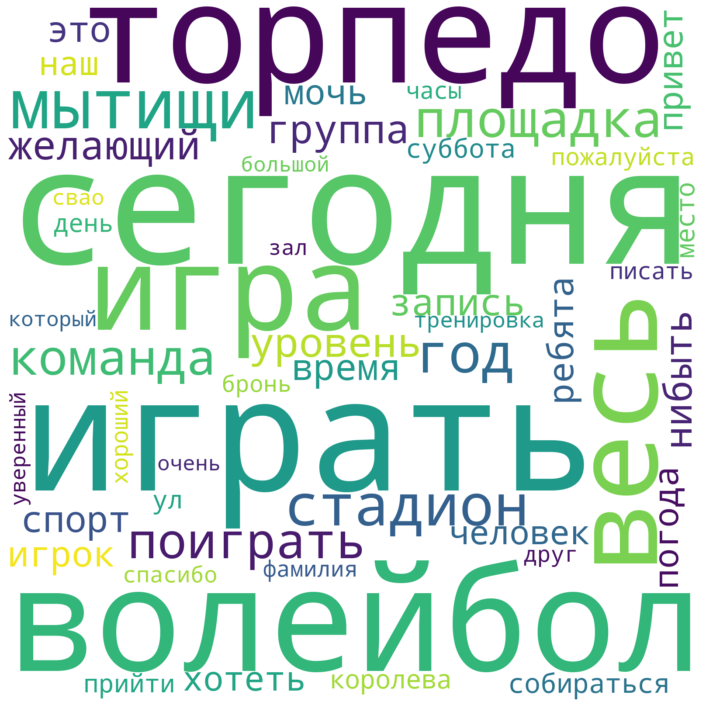

In [319]:
plt.figure(figsize=(10, 10))

wc = WordCloud(width=1600, height=1600, background_color="white", relative_scaling=0.5,
               collocations=True, min_font_size=10).generate_from_frequencies(dict(full_counter.most_common(50)))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()